## EECS 4404 Project 2: Lucas Aguiar - 217127630

### Objective: Best describe the variation in the different types of customers that a wholesale distributor interacts with.

#### Table of Contents
1. [EDA and Data-cleaning](#eda)
2. [Feature Scaling to Normalize data](#scaling)
3. [Finding Optimal Number of Features](#numfeat)
4. [Finding Optimal Num of Clusters (K-Means Clustering)](#kmeans)
5. [Principal Component Analysis](#pca)
6. [XGBoost Classifier](#xgb)
7. [Conclusion and Final Thoughts](#end)


## 1. EDA and Data Cleaning <a name='eda'></a>

#### Read in CSV file

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
pd.options.display.max_colwidth = 100
pd.options.mode.chained_assignment = None 
import seaborn as sns
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

wholesale = pd.read_csv('./wholesale.csv')
wholesale.head()

,Channel,Region,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen
0,2,3,12669,9656,7561,214,2674,1338
1,2,3,7057,9810,9568,1762,3293,1776
2,2,3,6353,8808,7684,2405,3516,7844
3,1,3,13265,1196,4221,6404,507,1788
4,2,3,22615,5410,7198,3915,1777,5185


In [2]:
wholesale.describe()

,Channel,Region,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen
count,440.000000,440.000000,440.000000,440.000000,440.000000,440.000000,440.000000,440.000000
mean,1.322727,2.543182,12000.297727,5796.265909,7951.277273,3071.931818,2881.493182,1524.870455
std,0.468052,0.774272,12647.328865,7380.377175,9503.162829,4854.673333,4767.854448,2820.105937
min,1.000000,1.000000,3.000000,55.000000,3.000000,25.000000,3.000000,3.000000
25%,1.000000,2.000000,3127.750000,1533.000000,2153.000000,742.250000,256.750000,408.250000
50%,1.000000,3.000000,8504.000000,3627.000000,4755.500000,1526.000000,816.500000,965.500000
75%,2.000000,3.000000,16933.750000,7190.250000,10655.750000,3554.250000,3922.000000,1820.250000
max,2.000000,3.000000,112151.000000,73498.000000,92780.000000,60869.000000,40827.000000,47943.000000


Looking at the above, we can see that there are no null values, and all variables are numerical, which makes data cleaning a lot easier, and not really necessary at all.

We can also see that 'channel' is a binary variable that ranges from 1 to 2, and region is a categorical variable that ranges from 1-3 (is either 1,2, or 3).

We will plot histograms to examine these variables and their frequencies.

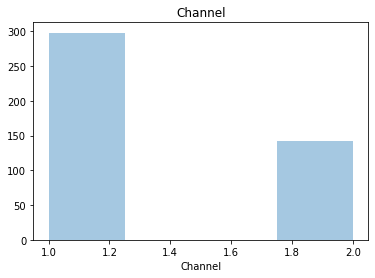

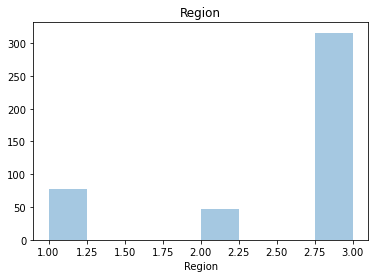

In [3]:
for feature in ['Channel', 'Region']:
    sns.distplot(wholesale[feature], kde=False)
    plt.title(feature)
    plt.show()

The rest of the variables (Fresh, Milk, Grocery, Frozen, Detergents_paper, and Delicassen) are continuous variables that seem to be a tally of the amount of items from that category spent. This means the variables are integers but can range widely, as can be seen from the very large STD of these columns.

We will plot histograms to further examine these continuous variables.

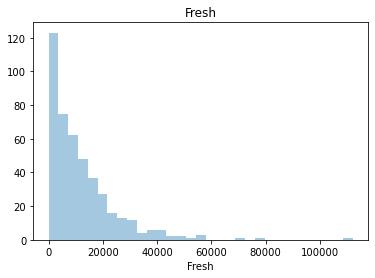

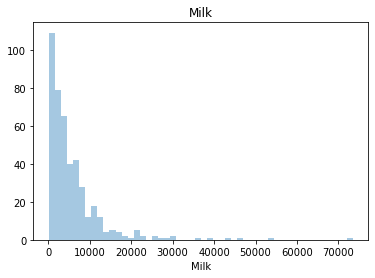

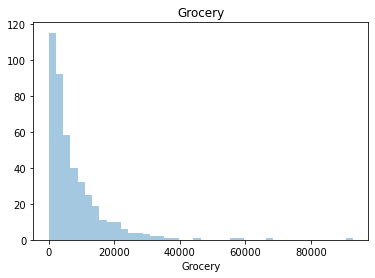

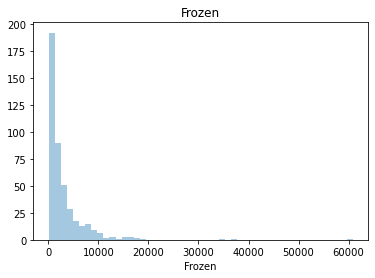

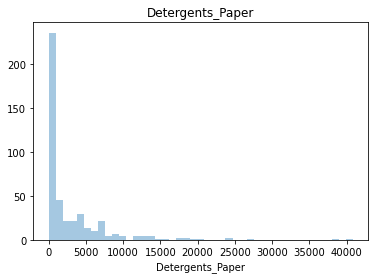

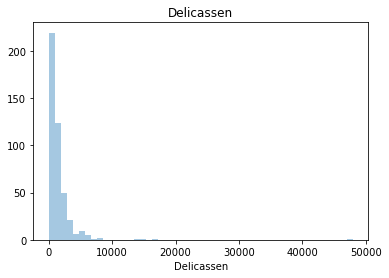

In [4]:
for feature in ['Fresh', 'Milk', 'Grocery', 'Frozen', 'Detergents_Paper', 'Delicassen']:
    sns.distplot(wholesale[feature], kde=False)
    plt.title(feature)
    plt.show()

As you can see by the histograms, all of these variables have most of their data concentrated between 0 and 5000, but have very long tails with many outliers. For our models to not 'chase' these tails, we need to transform the data before we can use it.

We will conduct transformations similar to what is done in lecture. 

We will use QQplots to determine the range of exponents to test this transformation on. 
Then we will perform Box-Cox transformation on our range of exponents, and pick the best one to transform our data.

We will test this on only one of the variables. 

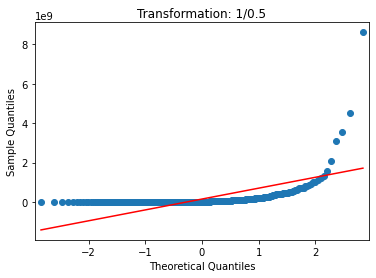

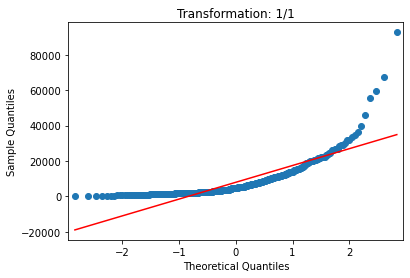

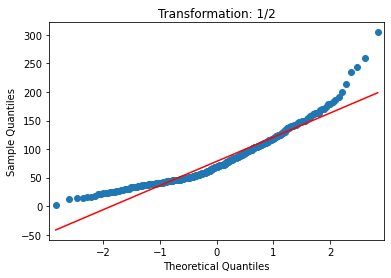

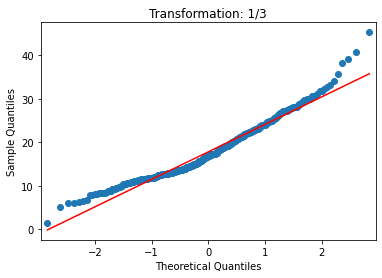

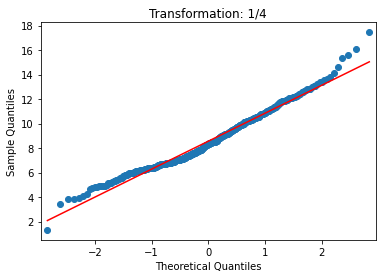

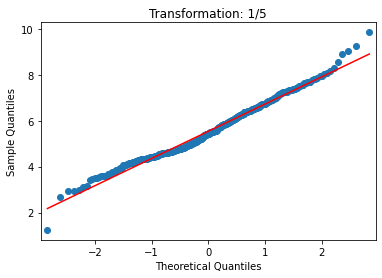

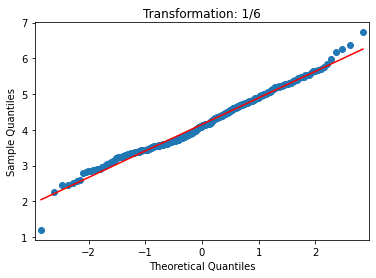

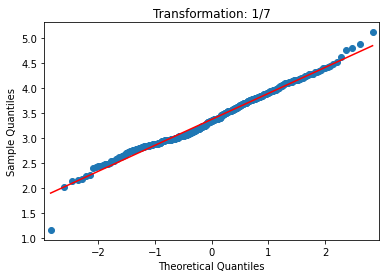

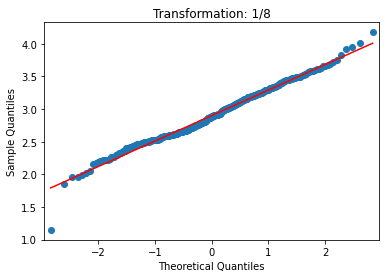

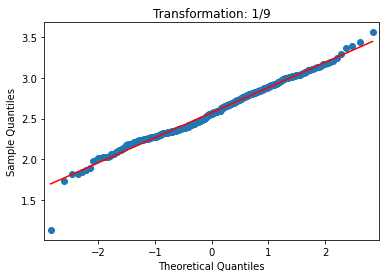

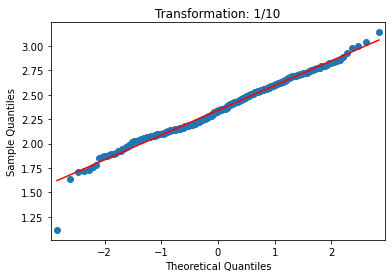

In [5]:
from statsmodels.graphics.gofplots import qqplot
for i in [0.5, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10]:
    data_t = wholesale['Grocery']**(1/i)
    qqplot(data_t, line='s')
    plt.title("Transformation: 1/{}".format(str(i)))

All values between 5 and 10 fit very well on the line, so we will use that range of exponents to perform box-cox transformations and pick our final transformation.

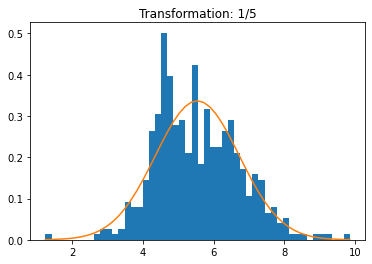

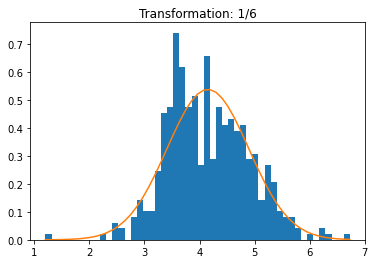

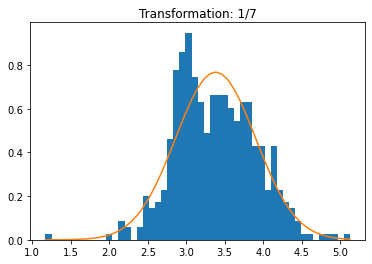

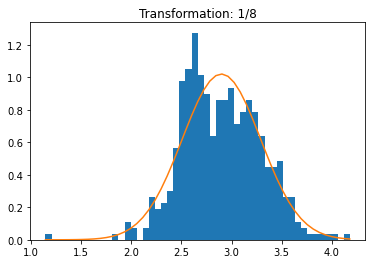

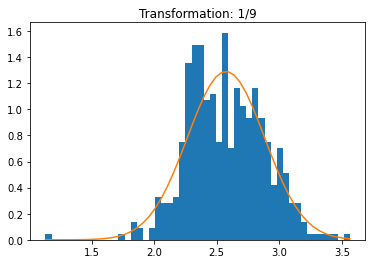

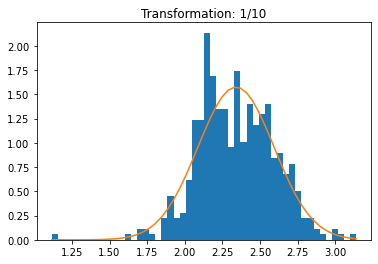

In [6]:
import scipy.stats
for i in [5, 6, 7, 8, 9, 10]:
    data_t = wholesale['Grocery']**(1/i)
    n, bins, patches = plt.hist(data_t, 50, density=True)
    mu = np.mean(data_t)
    sigma = np.std(data_t)
    plt.plot(bins, scipy.stats.norm.pdf(bins, mu, sigma))
    plt.title("Transformation: 1/{}".format(str(i)))
    plt.show()

Although none of the values perfectly meet the normal curve, they all make the data distribution much more compact, and therefore any of them would be good choices, as there wouldn't be much of a curve for models to chase. We are going to proceed by applying transformations using 8.

In [7]:
for feature in ['Fresh', 'Milk', 'Grocery', 'Frozen', 'Detergents_Paper', 'Delicassen']:
    wholesale[feature] = wholesale[feature].apply(lambda x: x**(1/8))

<AxesSubplot:>

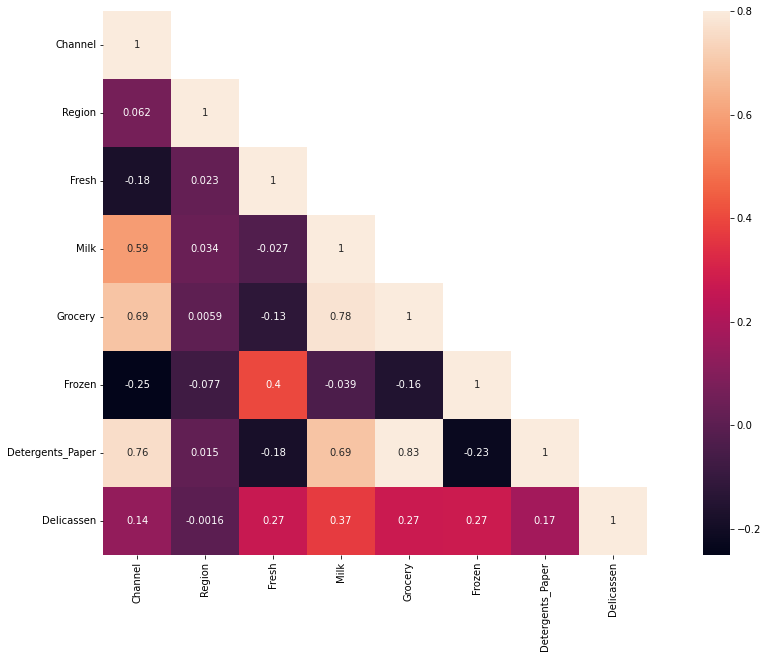

In [8]:
corr = wholesale.corr()
mask = np.array(corr)
mask[np.tril_indices_from(mask)] = False
fig,ax = plt.subplots()
fig.set_size_inches(20,10)
sns.heatmap(corr, mask=mask,vmax=.8, square=True,annot=True)

Shown above are the correlations for our data. There is a few of our continuous variables that have pretty high correlations with our target variable, Channel. Specifically Detergents_Paper, Grocery, and Milk.

Another thing we can see, is one of the categorical variables, Region, has extremely low (almost 0) correlation with every single one of our variables. Based on this analysis, I will drop this variable, as I believe it doesn't have any impact on the type of customer a wholesaler might have. 
Intuitively, this makes sense too, as every region of a country or province will need businesses of all types, leading to very low correlation.

Another thing we need to do is take our target variable 'Channel' and remap it. Currently channel is between 1 and 2, but it makes sense to make a binary variable have its values at 0 and 1 instead.

In [9]:
wholesale.drop('Region', axis=1, inplace=True)
remap = {1: 0, 2: 1}
wholesale['Channel'] = wholesale['Channel'].map(remap)
target = wholesale['Channel']
target

0      1
1      1
2      1
3      0
4      1
      ..
435    0
436    0
437    1
438    0
439    0
Name: Channel, Length: 440, dtype: int64

## 2. Feature Scaling to Normalize Data <a name='scaling'></a>

Since numbers range very widely for many of our variables, its important to normalize this data, and put it on the same scale, so that models can train quicker, and possibly even become better predictors.

We will use 2 scalers, *Standard Scaler* and *Min-Max Scaler*, and will use whichever produces more normalized data.

StandardScaler sets the mean value equal to 0, and scales data using variance against the mean (high value means it varies highly from the mean).

Min-Max Scaler sets all the values in the range [0,1] and sets the max value to 1. 

<AxesSubplot:ylabel='Density'>

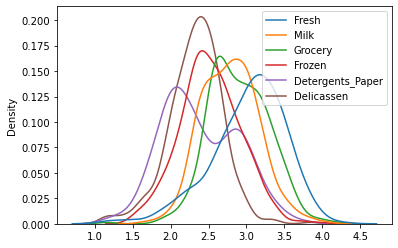

In [10]:
#Plotting UnScaled data to compare
sns.kdeplot(data=wholesale.drop('Channel', axis=1))

<AxesSubplot:ylabel='Density'>

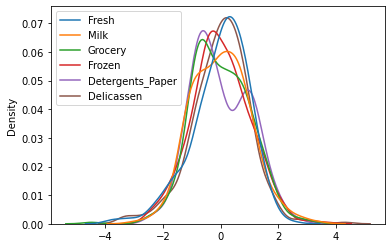

In [11]:
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

features = wholesale.drop('Channel', axis=1)
featurecolumns = features.columns

minmax_wholesale = features.copy(deep=True)
standard_wholesale = features.copy(deep=True)

s_scaler = StandardScaler()
m_scaler = MinMaxScaler()

s_scaler.fit(standard_wholesale)
standard_wholesale[featurecolumns] = s_scaler.transform(standard_wholesale[featurecolumns])

sns.kdeplot(data=standard_wholesale)

<AxesSubplot:ylabel='Density'>

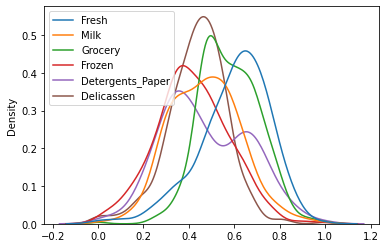

In [12]:
m_scaler.fit(minmax_wholesale)
minmax_wholesale[featurecolumns] = m_scaler.transform(minmax_wholesale[featurecolumns])

sns.kdeplot(data=minmax_wholesale)

Although both Standard and MinMax scaler put all features on the same scale, I am more inclined to use MinMaxScaler.

MinMaxScaler is a very simple scaler that sets the max variable to 1, and the min variable to 0, and scales data that way.

When looking at the plot for StandardScaler, the lines are extremely similar, probably due to the fact that the variance of each of the variables are very similar (and StandardScaler sets mean=0, and scales by variance).

When looking at the plot for MinMaxScaler, each variable or feature looks distinct and has its own slope. Since not every variable acts the same, I believe this will allow a model we create to pick up on trends much easier.

In [13]:
features = minmax_wholesale
features.head()

,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen
0,0.673978,0.622319,0.629105,0.186536,0.584974,0.486039
1,0.600595,0.624908,0.659199,0.425474,0.611932,0.518865
2,0.587975,0.607378,0.631140,0.466373,0.620562,0.711434
3,0.679973,0.321823,0.558292,0.606018,0.393109,0.519660
4,0.752134,0.530962,0.622927,0.533714,0.534063,0.654124


## 3. Finding Optimal Number of Features <a name='numfeat'></a>

Next we will perform RFECV, or Recursive Feature Elimination with Cross Validation, to find out the optimal number of features.

Often, some features in a dataset will not have enough relevance/correlation, and the data will fit towards these features that are not really necessary. This will lower test scores.

Recursive Feature Elimination essentially checks to see which features perform the best against data, given a number of features provided. For example, If I was only looking to use 3 features, it will give me the 3 best features.

When you are not sure which features to use, RFECV comes in handy, as it checks the best features for a range of feature numbers, and returns the optimal number of features that can be used. 

We will then plot the grid scores, to see how all of the different values perform, from 1 feature selected to 7 (as 1 of our 8 features will be used as a target).

We will be using "Channel" as our target variable, per the project requirements, and will use RandomForest as our model to predict scores.

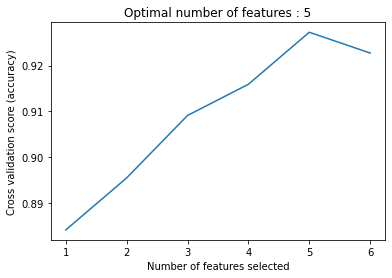

In [14]:
from sklearn.feature_selection import RFECV
from sklearn.ensemble import RandomForestClassifier
features = wholesale.drop('Channel', axis=1)

random = RandomForestClassifier()
rfecv = RFECV(estimator=random)
rfecv.fit(features,target)

plt.figure()
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score (accuracy)")
plt.title("Optimal number of features : %d" % rfecv.n_features_)
plt.plot(
    range(1, len(rfecv.cv_results_["mean_test_score"]) + 1),
    rfecv.cv_results_["mean_test_score"],
)
plt.show()

As you can see in the above graph, the RFE scores for # of features continues to increase, as features are increased, until it reaches 5/6 features, where it peaks and then decreases. Therefore the optimal number of features is 5

Though it is not required, I will perform RFE with 5 features, to identify and analyze which 5 of these features are the most optimal.

In [15]:
from sklearn.feature_selection import RFE

rfe = RFE(estimator=random, n_features_to_select=5, step=1) 
rfe.fit(features, target)

pd.Series(rfe.ranking_, index=list(features.columns.values)).sort_values(ascending=False).head(10)

Fresh               2
Milk                1
Grocery             1
Frozen              1
Detergents_Paper    1
Delicassen          1
dtype: int64

According to RFE, a model would be optimal if it used the following 5 features: **Milk**, **Grocery**, **Frozen**, **Detergents_Paper** and **Delicassen**, meaning that Fresh is the least optimal feature, and it would be best not to include this.

However, this is purely for analysis, and we will proceed with the original features.

## 4. Finding Optimal Number of Clusters (K-Means Clustering) <a name='kmeans'></a>

Next we will use K-Means Clustering, an unsupervised machine learning model, along with the elbow method, to find the optimal number of clusters (or types of customers) the wholesale distributor has. K-Means splits data into K groups or 'clusters'. We will perform K-Means clustering for the values from 2 to 15. 

We will then plot the SSE (Sum of Squared Errors), and the 'elbow' or the point at which increasing K does not add much benefits (line becomes somewhat linear), will be our optimal number of clusters.

2 : 314.8202414508376
3 : 266.3311781442293
4 : 234.71186159887336
5 : 211.52415408236715
6 : 193.9907631334969
7 : 182.26149147722083
8 : 173.75893956675003
9 : 164.04024269874344
10 : 154.4755905230293
11 : 149.70742803342023
12 : 145.42732072510287
13 : 138.09134372469816
14 : 134.31674817054642
15 : 129.95449213201834


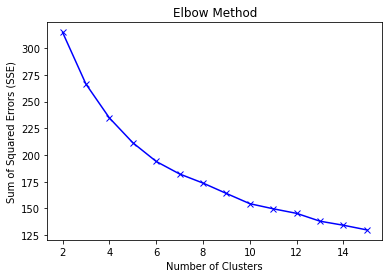

In [16]:
from sklearn.cluster import KMeans
from scipy.spatial.distance import cdist
K = range(2,16)
sse = []
mapping1 = {}
for k in K:
    kMean = KMeans(n_clusters=k)
    kMean.fit(features)    
    sse.append(kMean.inertia_)
    mapping1[k] = kMean.inertia_

for key, val in mapping1.items():
    print(f'{key} : {val}')
plt.plot(K, sse, 'bx-')
plt.title('Elbow Method')
plt.ylabel('Sum of Squared Errors (SSE)')
plt.xlabel('Number of Clusters')
plt.show()

Although the elbow is not extremely apparent, after approximately 5/6 clusters, the line begins to become linear. Since the difference between 5-6 is approximately 18, while the difference between 6-7 (and 7-8) is around 10, I will be more inclined to pick 6 as my elbow.

This means the optimal number of clusters is 6, and there may be around 6 types of customers that a wholesale distributor interacts with.

## 5. Principal Component Analysis <a name='pca'></a>
Next we will perform Principal Component Analysis on our data. PCA prioritizes keeping a datasets important info, without any redundancy, noise or outlifers. It creates new components out of data, that can be used as input variables for ML algorithms.

In [17]:
from sklearn.decomposition import PCA

pca = PCA()
wholesale_pca = pca.fit_transform(features)

print(pca.explained_variance_ratio_)
print('First 2 Components -', (pca.explained_variance_ratio_[0] + pca.explained_variance_ratio_[1]) * 100)
print('First 4 Components -',(pca.explained_variance_ratio_[0] + pca.explained_variance_ratio_[1] + pca.explained_variance_ratio_[2] + pca.explained_variance_ratio_[3])*100)

[0.45846759 0.28549631 0.1096825  0.07866441 0.04388149 0.02380771]
First 2 Components - 74.39638958797937
First 4 Components - 93.23107983324053


Shown above is the explained variance ratio for all 6 components (original features excluding categorical variables which don't get used in PCA). 

It also shows that the top 2 components account for 74.4% of total variance, while the top 4 components account for 93.2% of total variance. This means that one third (2/6) of PCA components only account for less than 7% of total variance, which is not very useful at all.

<AxesSubplot:>

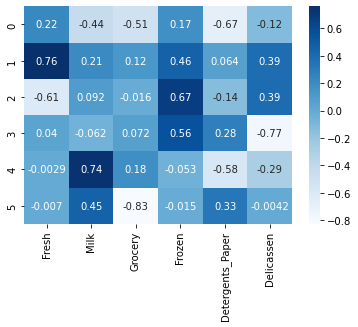

In [18]:
comps = pd.DataFrame(pca.components_, columns=features.columns)
sns.heatmap(comps, cmap="Blues", annot=True)

Shown above is a heatmap of the components generated by PCA, also showing what kind the variance it gets from each feature from the original data.

Next we will use 2 principal components, along with the number of clusters we obtained from using the elbow method, to visualize these clusters. PC1 will be plotted on the x-axis, and PC2 will be plotted on the y-axis. 

<AxesSubplot:xlabel='PC1', ylabel='PC2'>

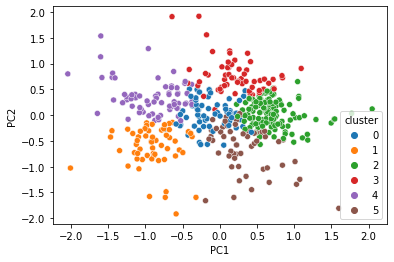

In [19]:
pca = PCA(2) 
wholesale_pca = pd.DataFrame(pca.fit_transform(features),columns=['PC1','PC2']) 
kmeans = KMeans(n_clusters=6).fit(features)
wholesale_pca['cluster'] = pd.Categorical(kmeans.labels_)
sns.scatterplot(x="PC1",y="PC2",hue="cluster",data=wholesale_pca)

As shown above, plotting the clusters this way helps distinguish them from eachother pretty well. Although there is some slight overlap in the border area of the clusters, they are pretty well defined.

## 6. XGBoost Classifier <a name='xgb'></a>
XGBoost is called the eXtreme Gradient Boosting Library, and it implements the Boosting supervised machine learning algorithm to make a prediction about data. We will perform XGBClassifier on the data, with 'Channel' as our target, as it was before.

We will train the model with a 5Fold CV, on 80% of the data, and use the remaining 20% of the data to test our model and predict the results. We will then report metrics of Accuracy, Precision, and Recall.

In [20]:
import xgboost as xgb
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings("ignore")
from sklearn.metrics import make_scorer, accuracy_score, precision_score, recall_score, f1_score


xtrain, xtest, ytrain, ytest = train_test_split(features, target, test_size=0.2, random_state=42)
model = xgb.XGBClassifier(objective="binary:logistic", random_state=42, eval_metric='error')

params = {"objective":"reg:squarederror",'colsample_bytree': 0.3,'learning_rate': 0.15,
                'max_depth': 5, 'alpha': 15}

data_dmatrix = xgb.DMatrix(data=xtrain,label=ytrain)
cv_results = xgb.cv(dtrain=data_dmatrix, params=params, nfold=5)
print('Training Results')
print(cv_results)
model.fit(xtrain, ytrain)
results = model.predict(xtest)
print('Accuracy - ', accuracy_score(results, ytest) * 100)
print('Precision - ', precision_score(results, ytest) * 100)
print('Recall - ', recall_score(results, ytest) * 100)

Training Results
   train-rmse-mean  train-rmse-std  test-rmse-mean  test-rmse-std
0         0.492942        0.001114        0.494637       0.001701
1         0.472679        0.013709        0.478858       0.009199
2         0.452313        0.016885        0.458443       0.010499
3         0.436529        0.017435        0.443005       0.013203
4         0.423648        0.025850        0.430159       0.025143
5         0.409468        0.029887        0.416492       0.025359
6         0.396946        0.028772        0.405469       0.023257
7         0.383072        0.025688        0.392914       0.021658
8         0.381299        0.026640        0.390995       0.023325
9         0.374014        0.026247        0.383737       0.025389
Accuracy -  92.04545454545455
Precision -  91.30434782608695
Recall -  80.76923076923077


The top 3 iterations of the 5fold CV training are pretty accurate with around 65-85% mean accuracy. Once training the model and predicting it on our test data, we receive even better results.

We get an accuracy of 92.04%, precision of 91.3%, and the best performing metric, a recall of 80.76%

## 7. Conclusion and Final Thoughts <a name='end'></a>

Analysis of the dataset has led us to come to many conclusions.

#### Not all of the features have a high impact on our data

Region, had such low correlation with the other data, that we dropped it all together. Perhaps this data field may be useful for other things, but for our purpose of analyzing the type of customers and also predicting 'Channel', it was completely useless.

Also, after performing RFECV, we realized that our data would actually perform better at predicting 'Channel' if it had 5 variables, meaning that 'Fresh' although may be useful in some capacity, made our models perform slightly worse when we included it.

#### There are 6 distinct types of customers from the wholesaler

Using the elbow method, we determined that the optimal number of clusters, or 'types' of customers that this wholesaler has. When we plotted these clusters against 2 principal components (containing 75% of original variance), we were able to see these clusters were quite distinct from one another.

#### Our Model

Using XGBoost, Channel was predicted with a high degree of accuracy of over 90%. If one wanted to predict this target, our XGBoost model would be a good candidate.